<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span></li><li><span><a href="#TODOs" data-toc-modified-id="TODOs-2"><strong>TODOs</strong></a></span></li><li><span><a href="#Goal" data-toc-modified-id="Goal-3">Goal</a></span></li><li><span><a href="#Keywords-selection" data-toc-modified-id="Keywords-selection-4">Keywords selection</a></span><ul class="toc-item"><li><span><a href="#GDPR-related-keywords" data-toc-modified-id="GDPR-related-keywords-4.1">GDPR-related keywords</a></span></li><li><span><a href="#Popular-articles" data-toc-modified-id="Popular-articles-4.2">Popular articles</a></span></li></ul></li><li><span><a href="#Web-Scraping" data-toc-modified-id="Web-Scraping-5">Web Scraping</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-5.1">Setup</a></span></li><li><span><a href="#Popular-articles-selection" data-toc-modified-id="Popular-articles-selection-5.2">Popular articles selection</a></span></li><li><span><a href="#Article-Pageviews" data-toc-modified-id="Article-Pageviews-5.3">Article Pageviews</a></span></li><li><span><a href="#Remarks" data-toc-modified-id="Remarks-5.4">Remarks</a></span></li></ul></li><li><span><a href="#I.-Exploratory-Data-Analysis" data-toc-modified-id="I.-Exploratory-Data-Analysis-6">I. Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#A.-Cleaning-and-handling-missing/undefined-values" data-toc-modified-id="A.-Cleaning-and-handling-missing/undefined-values-6.1">A. Cleaning and handling missing/undefined values</a></span></li><li><span><a href="#B.-Consistency-in-Datasets" data-toc-modified-id="B.-Consistency-in-Datasets-6.2">B. Consistency in Datasets</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-6.3">Visualization</a></span></li><li><span><a href="#C.-Outliers-articles-removal" data-toc-modified-id="C.-Outliers-articles-removal-6.4">C. Outliers articles removal</a></span></li><li><span><a href="#D.-Monthly-Aggregation" data-toc-modified-id="D.-Monthly-Aggregation-6.5">D. Monthly Aggregation</a></span></li><li><span><a href="#E.-Outliers-monthly-removal" data-toc-modified-id="E.-Outliers-monthly-removal-6.6">E. Outliers monthly removal</a></span></li></ul></li><li><span><a href="#II.-Generic-Methods" data-toc-modified-id="II.-Generic-Methods-7">II. Generic Methods</a></span><ul class="toc-item"><li><span><a href="#A.-Mean-Computation" data-toc-modified-id="A.-Mean-Computation-7.1">A. Mean Computation</a></span></li><li><span><a href="#B.-ITS-Regression" data-toc-modified-id="B.-ITS-Regression-7.2">B. ITS Regression</a></span></li><li><span><a href="#C.-Plotting" data-toc-modified-id="C.-Plotting-7.3">C. Plotting</a></span></li><li><span><a href="#D.-Analysis-of-plots" data-toc-modified-id="D.-Analysis-of-plots-7.4">D. Analysis of plots</a></span></li></ul></li><li><span><a href="#III.-GDPR-Adoption" data-toc-modified-id="III.-GDPR-Adoption-8">III. GDPR Adoption</a></span><ul class="toc-item"><li><span><a href="#A.-Data-formatting" data-toc-modified-id="A.-Data-formatting-8.1">A. Data formatting</a></span></li><li><span><a href="#B.-Mean-Computation" data-toc-modified-id="B.-Mean-Computation-8.2">B. Mean Computation</a></span></li><li><span><a href="#C.-ITS-Regression" data-toc-modified-id="C.-ITS-Regression-8.3">C. ITS Regression</a></span></li></ul></li><li><span><a href="#GPDR-Beggining-of-enforcement" data-toc-modified-id="GPDR-Beggining-of-enforcement-9">GPDR Beggining of enforcement</a></span><ul class="toc-item"><li><span><a href="#A.-Monthly-Aggregation" data-toc-modified-id="A.-Monthly-Aggregation-9.1">A. Monthly Aggregation</a></span></li><li><span><a href="#B.-Mean-Computation" data-toc-modified-id="B.-Mean-Computation-9.2">B. Mean Computation</a></span></li><li><span><a href="#C.-ITS-Regression" data-toc-modified-id="C.-ITS-Regression-9.3">C. ITS Regression</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10">Conclusion</a></span></li></ul></div>

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Allow import of custom modules from the "src" folder
import sys
sys.path.insert(0, 'src/')

# Standard packages for data analysis 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
sns.set(style='whitegrid')

# Web scraping
from scrape_wiki import PageviewsClient
from update_keywords import read_keywords

# Other
from functools import reduce
import math

In [3]:
# Path management
data_path = "data/"

import os
if not os.path.exists('report'):
    os.mkdir('report')
if not os.path.exists('figs'):
    os.mkdir('figs')

In [4]:
# Make incredibly good looking plot with ipypublish, which basically
# overrides matplotlib default parameters and make plots more latex-looking

# Enable fancy plots if you want to generate plots for the article
# otherwise keep False, since it lengthens rendering time
fancy_plots = False

if fancy_plots:
    from ipypublish import nb_setup
    rcparams = {
        'axes.titlesize':13,
        'axes.labelsize':7,
        'xtick.labelsize':6,
        'ytick.labelsize':6
    }
    plt = nb_setup.setup_matplotlib(rcparams=rcparams)
    # Override a few parameters again with seaborn
    sns.set(style='whitegrid')

# **TODOs** 

* Modify titles numbers (I, II, III) once it won't change
* Add decriptions for better understanding of our thinking
* change x axis values (better formatting) in plots
* TODO dans cleaning and hadling missing values
* Don't forget to replot the small multiples in the notebook
* Change bootstrap itteration 200 -> 2000

---

# Goal

This  paper  is  an  extension  research  to the article *Chilling effects: online surveil-lance  and  Wikipedia  use* from  Jonathan W. Penney. This study analyses the Wikipedia traffic of german articles related to **the General Data Protection Regulation (GDPR)** topic and their changing trends following the announcement of the regulation adoption in April 2016 and the day the regulation became effective in May 2018. The paper tests the hypothesis that traffic to GDPR-related Wikipedia articles increased after the regulation was first put into effect, implying a reverse chilling effect on the European population. The study will provide answers to this research question through the Wikipedia pageviews exploration trends before and after the aforementioned dates, using two Interrupted Time Series (ITS) design.

The setup procedure is the following:
* Create a new treatment dataset with german Wikipedia articles
* Scrape the articles pageviews of the treatment group
* Create a new control dataset with popular german Wikipedia articles in the period of analysis through pageviews scraping
* Clean the extracted information by checking first for consistency, then treat missing values and remove outliers.
* Aggregate the articles' pageviews in a monthly dataframe structure.

The analysis procedure is the following:
* Plot the aggregated pageviews means of the treatment and control groups, for the pre- and post-intervention event.
* Plot the linear regression trends of the treatment and control groups, for the pre- and post-intervention event.
* Analyse and compare the obtained trends and results

One will observe that the results obtained are unsatisfactory evidence to the plausible reverse chilling effect following the adoption of the GDPR regulation, led by the obtainable corrupted data.

---

# Keywords selection

## GDPR-related keywords

Selected GDPR-related keywords was mainly done by manual selection of relevant articles, we simply wrote them in a text file and we load them in the cells below:

In [5]:
# Setup path and settings
keywords_GDPR = data_path + 'GDPR_{}.txt'
language = 'de'

In [6]:
# Load list of keywords with our custom function
keywords = read_keywords(keywords_GDPR.format(language))
sorted(keywords)[:5]

['Anonymisierung und Pseudonymisierung',
 'Anonymität',
 'Automatische Identifikation und Datenerfassung',
 'Big Data',
 'Business Intelligence']

## Popular articles

One can find the selection of popular Wikipedia articles under the Web Scraping section.

---

# Web Scraping

In this section, we reproduce the steps performed to obtain the dataset we will work on. This is mainly a summary of what is shown in the [Scraping](Scraping.ipynb) notebook. 

## Setup 

According to the [Wikipedia REST API rules](https://wikimedia.org/api/rest_v1/), we must specify a contact address as the `User-Agent` for queries to the database.

In [7]:
# Set contact address
contact = 'matthias.zeller@epfl.ch'

# Instanciate query function
p = PageviewsClient(contact)

In [8]:
# Parameters to request article views
params = {
    'agent': 'user',
    'start': '20150401', # 1st April 2015
    'end':   '20190531'  # 31th May 2019
}

In [9]:
from concurrent.futures import ThreadPoolExecutor

# Helper functions
def request_top(dates, domain=language, limit=500):
    """
    Wraps the function PageviewsClient.top_articles.
    
    Parameters 
    ----------
    dates: list 
           List of dictionnaries with keys 'year', 'month', 'day'
    domain: str
            Specifies the Wikipedia project (en, de, fr, ...)
    limit: int
           Number of top articles to fetch for a given date
    
    Returns
    -------
    df : pandas.DataFrame
        Dataframe with columns year, month, day, views, article, rank
    """
    def fetch_date(d):
        try:
            df = p.top_articles(domain, **d, limit=limit)
        except Exception:
            # Happens if data not available
            return pd.DataFrame()
        
        df = pd.DataFrame(df)
        df['year'] = d['year']
        df['month'] = d['month']
        df['day'] = d['day']
        return df
    
    domain = domain + '.wikipedia'
    
    # Fetch with parallel requests
    with ThreadPoolExecutor(10) as executor:
        res = list(executor.map(fetch_date, dates))
    
    # Format results in a DataFrame
    res = pd.concat(res, ignore_index=True)
    # Replace None -> np.nan
    res = res.applymap(lambda elem: np.nan if elem is None else elem)
    
    res['language'] = domain.split('.')[0]
    
    return res


def request(articles, domain=language, **kwargs):
    """
    Wraps the function PageviewsClient.article_views
    
    Parameters
    ----------
    articles : list
              List of Wikipedia article names
    domain : str
            Wikipedia project (de, en, es, fr...)
    kwargs
            Additionnal arguments that override `params` and passed to article_views()
            
    Returns
    -------
    df : pandas.DataFrame
         Dataset with columns being articles and index are dates
    """
    wrapped_kwargs = params.copy()
    wrapped_kwargs.update(kwargs)
    domain = domain + '.wikipedia'
    
    # Fetch
    res = p.article_views(articles=articles, project=domain, **wrapped_kwargs)
    
    # Format results in a DataFrame
    res = pd.DataFrame(res).T
    # Replace None -> np.nan
    res = res.applymap(lambda elem: np.nan if elem is None else elem)
    # Sort by dates
    res.sort_index(inplace=True)
    
    return res

## Popular articles selection

We will use (a modified version of) the `top_articles` function from the [python-mwviews](https://github.com/mediawiki-utilities/python-mwviews/blob/master/mwviews/api/pageviews.py) package to fetch the most popular Wikipedia articles for our given time period. We fetch articles that are popular during a whole month with `day='all-days'` argument.

We use the following strategy:

1. Fetch the monthly top 400 articles for every date specified
1. Compute and retain only the articles that appear as a top article in each month
1. Filter out special articles (e.g. home page)

In [10]:
# Define the time range of interest
dates = [
    {'year': year, 'month': month, 'day': 'all-days'}
    for year in [2015, 2016, 2017, 2018]
    for month in range(1, 13)
] + [
    {'year': 2019, 'month': month, 'day': 'all-days'}
    for month in range(1, 6)
]

top = request_top(dates, limit=400)

In [11]:
top.head()

,article,views,rank,year,month,day,language
0,Wikipedia:Hauptseite,89923322,1,2015,7,all-days,de
1,Spezial:Suche,12288633,2,2015,7,all-days,de
2,Spezial:Anmelden,3932424,3,2015,7,all-days,de
3,Special:Search,2551705,4,2015,7,all-days,de
4,Hauptseite,1769900,5,2015,7,all-days,de


In [12]:
# Quick sanity check
top.groupby(['year', 'month']).article.nunique().unique()

array([400])

We indeed have 400 articles per entry (i.e. per month). We now retain the articles that appear in each month:

In [13]:
# Initialize iterator for sets of articles per month
it = (set(article_lst) for _, article_lst in top.groupby(['year', 'month']).article)

# Compute intersection of lists of articles
intersect = list(reduce(
    lambda accumulator, article_list: accumulator.intersection(article_list),
    it
))

In [14]:
# Define list of "special" articles
specials = [
    'Spezial:', 'Wikipedia:', 'Datei:', 'Benutzer:', 'Special:', 'Hauptseite'
]

# Discard special articles from the current list
selection = [
    art for art in intersect if not any(map(lambda special: special in art, specials))
]

print(f'Full list has length {len(intersect)}, filtered list has length {len(selection)}')
selection[:5]

Full list has length 53, filtered list has length 41


['Niederlande', 'Europäische_Union', 'Berlin', 'Frankreich', 'Game_of_Thrones']

We can now extract those 39 popular articles and format a data set suited for downstream analyses:

In [15]:
# Extract selected articles
ctrl = top[top.article.isin(selection)].reset_index(drop=True).copy()
# Create date column
ctrl['date'] = list(map(lambda tpl: f'{tpl[0]}-{tpl[1]}', zip(ctrl.year, ctrl.month)))
ctrl.date = pd.to_datetime(ctrl.date)
# Keep relevant columns
ctrl = ctrl[['article', 'date', 'views', 'language']]
ctrl.columns = ['Article', 'Date', 'Pageviews', 'Language']

ctrl.head()

,Article,Date,Pageviews,Language
0,Deutschland,2015-07-01,477014,de
1,Game_of_Thrones,2015-07-01,360283,de
2,Wikipedia,2015-07-01,194898,de
3,Vereinigte_Staaten,2015-07-01,192909,de
4,Schweiz,2015-07-01,169767,de


## Article Pageviews

In [16]:
# Helper function
def format_dataset(df, language):
    out = pd.DataFrame(df.unstack()).reset_index()
    out.columns = ['Article', 'Date', 'Pageviews']
    out['Language'] = language
    return out

In [17]:
# We use the helper function "request" defined above
# and the list of keywords also loaded above
df = request(keywords, language)
df = format_dataset(df, language)

df.head()

,Article,Date,Pageviews,Language
0,Verschwiegenheitspflicht,2015-04-01,NaN,de
1,Verschwiegenheitspflicht,2015-04-02,NaN,de
2,Verschwiegenheitspflicht,2015-04-03,NaN,de
3,Verschwiegenheitspflicht,2015-04-04,NaN,de
4,Verschwiegenheitspflicht,2015-04-05,NaN,de


### Remarks

The Wikipedia REST API cannot provide data anterior to July 2015, so we either have missing values (as in `df`) or do not take top articles from April 2015 to June 2015 into account. 

---
# I. Exploratory Data Analysis

## A. Cleaning and handling missing/undefined values

Undefined values are any non-positive numerical or non-numerical values. In case of missing values, we will discuss the possible fixes and consequently decide on our way to handle them.

We check missing values in the study group:

In [18]:
mask_missing = df.isna().any(axis=1)
df[mask_missing].sort_values('Date')

,Article,Date,Pageviews,Language
0,Verschwiegenheitspflicht,2015-04-01,NaN,de
24352,Business_Intelligence,2015-04-01,NaN,de
22830,Informationsmanagement,2015-04-01,NaN,de
53270,Verordnung_(EU),2015-04-01,NaN,de
54792,Individualrecht,2015-04-01,NaN,de
...,...,...,...,...
22787,Internet_Privacy_Act,2019-04-19,NaN,de
22809,Internet_Privacy_Act,2019-05-11,NaN,de
22821,Internet_Privacy_Act,2019-05-23,NaN,de
22828,Internet_Privacy_Act,2019-05-30,NaN,de


We expect to get missing values before 1st July 2015, as those data are not available via Wikipedia REST API. However, we get some missing values after 1st July 2015, we investigate the affected articles:

In [19]:
# Define the binary mask whose values are True for dates after 1st July 2015
mask_post_july2015 = (df.Date >= '2015-07-01')
print(f'There are {len(mask_post_july2015)} days starting from 1st July 2015.')

# Find the dates and articles for which we have unexpected missing values
df_nan = df[mask_missing & mask_post_july2015].groupby('Article').Date.unique()
df_nan = pd.DataFrame(df_nan)

# Numer of dates for which there are NaNs
df_nan['N_missing'] = df_nan.Date.apply(len)

df

df_nan

There are 57836 days starting from 1st July 2015.


,Date,N_missing
Article,,
Digitale_Rechte,"[2015-07-01T00:00:00.000000000, 2015-07-02T00:...",261
Individualrecht,[2017-06-03T00:00:00.000000000],1
Internet_Governance,"[2016-01-22T00:00:00.000000000, 2017-03-31T00:...",12
Internet_Privacy_Act,"[2015-07-11T00:00:00.000000000, 2015-08-05T00:...",111


To get a feeling of how those missing values are distributed, we plot the individual time series starting from 1st July 2015 and add vertical lines for missing days:

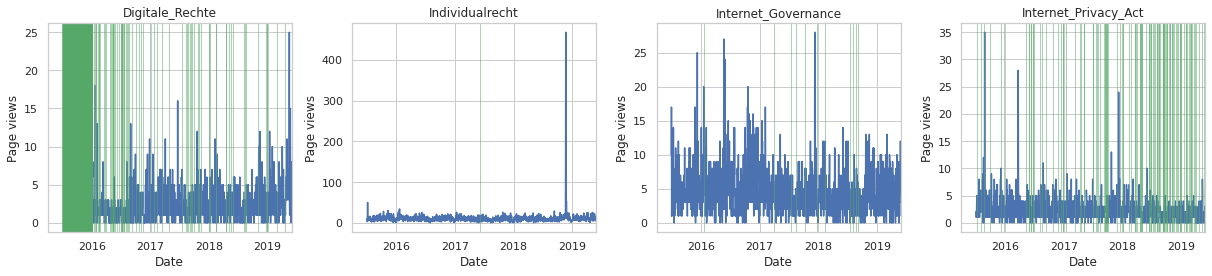

In [20]:
articles = df_nan.index
fig, axes = plt.subplots(1, len(articles), figsize=(17, 4))

for art, ax in zip(articles, axes):
    df[df.Article == art].set_index('Date').plot(y='Pageviews', ax=ax, legend=None)
    for date_missing in df_nan.loc[art].Date:
        ax.axvline(date_missing, color='g', lw=0.5)
    
    ax.set_ylabel('Page views')
    ax.set_title(art)
    
plt.tight_layout()

There is a block of NaNs for digitale Rechte before 2016, which is problematic. Individualrecht is not a problem as there is a single missing value. For the two last articles, NaNs are scattered enough to be considered as still valid. 

We remove the missing values:

In [21]:
df = df[~mask_missing]

We check for control group:

In [22]:
ctrl[ctrl.isna().any(axis=1)]

,Article,Date,Pageviews,Language


Nothing has to be done.

## B. Consistency in Datasets

## Visualization

We plot and examine each article views individually to identify outliers and absurd data:

In [23]:
def plot_pageviews_grid(df_longitudinal, n_col=5, yscale='log', rolling_window=None):
    """Plot the time series of several articles, each having its individual subplot ("small multiples").
        
    Parameters 
    ----------
    df_longitudinal : pandas.DataFrame
        pageviews in longitudinal format
    n_col : int
        number of columns for the plot, number of rows are automatically deduced
    yscale : string
        log or linear, passed to ax.set_yscale
    rolling_window : int
        size of the mean rolling window, units depends on dates in df_longitudinal
    """
    if df_longitudinal.Language.nunique() > 1:
        raise ValueError
        
    articles = df_longitudinal.Article.unique()
    if 'Date' in df_longitudinal.columns:
        df_longitudinal = df_longitudinal.set_index('Date')
    if yscale == 'log':
        df_longitudinal = df_longitudinal.replace(0, np.nan)
    
    # Init plotting
    colors = sns.color_palette(n_colors=len(articles))
    n_row = math.ceil(len(articles) / n_col)
    fig, axes = plt.subplots(n_row, n_col, figsize=(3*n_col + .5, 2.25*n_row + .5), sharex=True, sharey=True)
    
    # Plotting loop
    for article, ax, col in zip(articles, axes.ravel(), colors):
        # Extract article data
        subdf = df_longitudinal[df_longitudinal.Article == article].copy()
        # Smooth data
        if rolling_window is not None:
            subdf.Pageviews = subdf.Pageviews.rolling(rolling_window).mean()
        # Plot
        subdf.plot(y='Pageviews', ax=ax, legend=False, color=col)
        article = article.replace('_', ' ')
        ax.set_title(article)
        ax.set_yscale(yscale)
        
    # Aesthetics
    for ax in axes[-1]:
        ax.set_xlabel('Date')
    for ax in axes[:, 0]:
        ax.set_ylabel('Views')
        #ax.tick_params('y', left=True, which='minor',)# reset=True)
        
    plt.tight_layout()

## C. Outliers articles removal

Remove articles outliers in each of the groups depending on the results obtained in the small multiples above.

For the treatment group:
- we remove the following articles: Individualrecht, Datenvernichtung, Zensur im Internet, Vorratsdatenspeicherung. Indeed, these artciles have a unique spike at different moments during the period of analysis, which causes outliers in our aggregation of all articles.
- we remove Cyber-terrorismus article. This article is sensitive to the cyber attacks news and therefore oscillate a lot. This will hence impact our total articles pageviews when it isn't a critical keyword for the GDPR analysis. Therefore it was removed.

For control:
- we remove the articles which have a unique important spike. This is because we assume there was an important event which has impacted the trend and thus resulted in the unique spike. These articles are the following: Italien, Vereinigtes Königreich, Berlin, Hamburg, Polen, Niederlande.
- we remove the movies articles because their trend depend on the announcement of a new season. There articles are the following: Game of thrones, Grey's Anatomy et The Walking Dead

In [24]:
# Create the list of articles outliers to remove
outliers_treatment = ['Individualrecht', 'Datenvernichtung', 'Zensur_im_Internet', 'Vorratsdatenspeicherung', \
                     'Cyber-Terrorismus']
outliers_control = ['Italien', 'Vereinigtes_Königreich', 'Berlin', 'Hamburg', 'Polen', 'Niederlande', \
                   'Game_of_Thrones', 'Grey’s_Anatomy', 'The_Walking_Dead_(Fernsehserie)']

In [25]:
# Remove the outliers from the treatment and control groups
df = df[~df['Article'].isin(outliers_treatment)]
ctrl = ctrl[~ctrl['Article'].isin(outliers_control)]

## D. Monthly Aggregation
The data in our reference paper $\text{Chilling Effects: Online Surveillance and Wikipedia Use}$ (*Jonathan W. Penney*), data is aggregated on a monthly basis and further computations are done on this transformation.

In [26]:
def agg_monthly(df) :
    """
    Aggregates the pageviews in a monthly fashion. Returns a DataFrame with only the numerical columns summed.
    Note : Sets the index to date.
    
    Parameters 
    ----------
    df : pd DataFrame
        df should have at least 3 columns containing `Article`, `Date` and `Pageviews`. Column with `Date` should be named 'Date'.
    """
    # Aggregate monthly
    df_month = df.set_index('Date')
    df_month = df_month.resample('M').sum()
    # Verify period
    print(f"The formatted dataset correctly spans from {df_month.index.min().date()} to {df_month.index.max().date()}.\n")
    
    return df_month

In [27]:
# Count the total number of views of treatment and control wikipedia article per month.
df_monthly = agg_monthly(df)
df_monthly_ctrl = agg_monthly(ctrl)

The formatted dataset correctly spans from 2015-07-31 to 2019-05-31.

The formatted dataset correctly spans from 2015-07-31 to 2019-05-31.



## E. Outliers monthly removal

We remove the January monthly agrgegated pageviews as they have an important drop of pageviews in many articles in the treatment and control groups, as illustrated on the small multiples above.

Below we first plot the aggregated articles pageviews to illustrate their evolution.

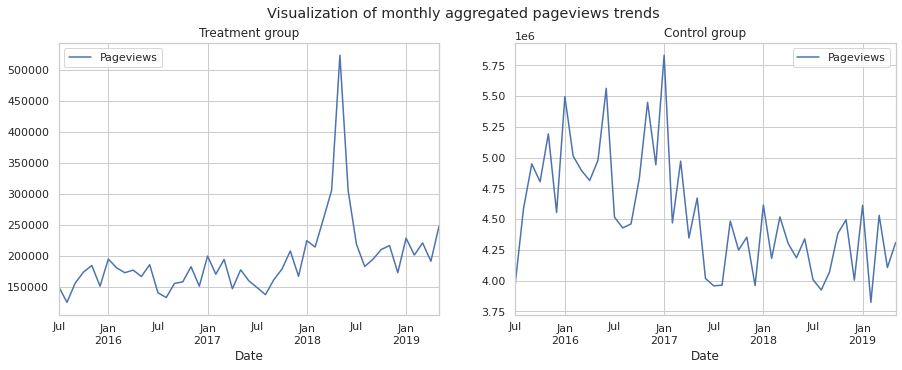

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Plot the monthly aggregated pageviews for both groups
df_monthly.plot(ax = ax1, title='Treatment group');
df_monthly_ctrl.plot(ax = ax2, title='Control group');
fig.suptitle("Visualization of monthly aggregated pageviews trends");

We now proceed to remove the january months as they could impact the general trend of our linear regressions. Indeed there are many plausible interpretation of these dropping in pageviews for many of the articles in the treatment group especially, one being that the people who tend to visit these articles are employees working for security and data departments who take holidays during this period of the year.

In [29]:
# Remove the January aggregated pageviews
df_monthly = df_monthly[~(df_monthly.index.month == 12)]
df_monthly_ctrl = df_monthly_ctrl[~(df_monthly_ctrl.index.month == 12)]

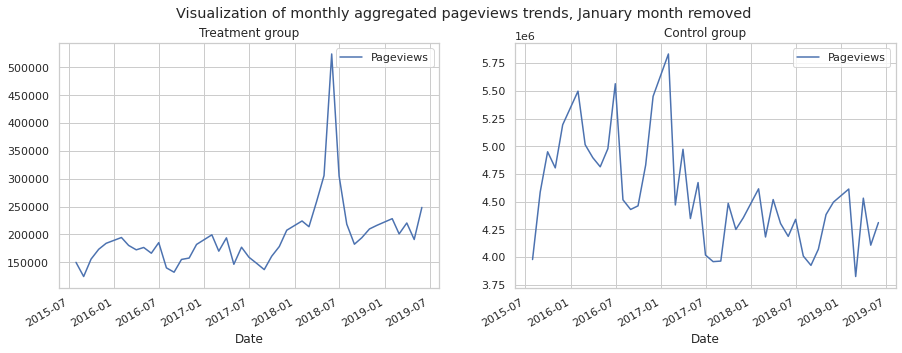

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Plot the monthly aggregated pageviews for both groups
df_monthly.plot(ax = ax1, title='Treatment group');
df_monthly_ctrl.plot(ax = ax2, title='Control group');
fig.suptitle("Visualization of monthly aggregated pageviews trends, January month removed");

---
# II. Generic Methods

## A. Mean Computation
The first analysis technique done in the paper is a comparison of means before and after the interruption event. Let us write the methods for this purpose given a monthly pageviews dataset.

In [31]:
def divide_around_interruption(df, interruption, verbose=False) :
    """
    Divides the dataset into a pre-interruption dataset and a post-interruption dataset. Returns 2 dataframes in (pre, post) order.
    Note : The month of the interruption is included in the post-interruption dataset.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    """
    # Get pd.Timestamp object
    revelations = pd.to_datetime(interruption)

    # Creating both datasets
    pre = df.loc[df.index < revelations]
    post = df.loc[df.index > revelations]
    if verbose :
        print("Pre-interruption pageviews:\n", pre)
        print("\nPost-interruption pageviews:\n", post)

    # Verifying operation
    if verbose : 
        print("Verifying coherence for split around interruption date...")
    assert(df.size == (pre.size + post.size))
    if verbose :
        print(df.size == (pre.size + post.size))
        
    return pre, post

**TODO: the function below is not used**

In [32]:
def compute_mean_around_interruption(df, interruption, verbose=False) :
    """
    Computes the mean number of pageviews before and after the interruption date. 
    Returns 2 means (2-tuple of numpy.float64) in (pre, post) order.
    Note : The month of the interruption is included in the post-interruption dataset.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    """
    pre, post = divide_around_interruption(df, interruption, verbose=verbose)
    return pre.mean()[0], post.mean()[0]

## B. ITS Regression 
Following the formula of segmented regression of an interrupted time series (ITS) : 
$$
Y_{t} = \beta_{0} \cdot \text{time}+\beta_{2} \cdot \text{intervention}+\beta_{3} \cdot \text{postslope}+\epsilon_{1}
$$
We define in the following the methods to perform such a regression.

In [33]:
def extract_around_date(df, ref_date, time_delta):
    """Filtzer data from `df` corresponding to dates ref_date +/- time_delta
    
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe containing at least a 'Date' column (or an index with Dates)
    ref_date: string or pandas.Timestamp
        Reference date around which to select the data
    time_delta: pandas.Timedelta or numpy.timedelta64
        Time period to extract from `df` before and after `ref_date`
    """
    ref_date = pd.to_datetime(ref_date)
    if 'Date' in df.columns:
        df = df.set_index('Date')
    output_df = df.loc[(df.index > (ref_date - time_delta)) \
                     & (df.index < (ref_date + time_delta))]
    return output_df

In [34]:
def fit_model(formula, data, predictor, seed, return_res=False):
    '''
    Output a linear prediciton using an ordinary least squares linear regression.
    
    Parameters
    ----------
    formula : string
        the equation describing the model using patsy formula syntax
    data : pd.DataFrame
        the dataframe containing the monthly grouped time series elements for fitting
    predictors : pd.DataFrame
        the dataframe containing the monthly grouped time series elements for predicting
    seed : int
        a seed for consistency
    '''
    # Declares model
    mod = smf.ols(formula=formula, data=data)

    # Fits the model (finds the optimal coefficients, adding a random seed for consistency)
    np.random.seed(seed)
    res = mod.fit()

    # Optimal Coefficients
    coefficients = res.params.values

    # Compute predictions
    ypred = res.predict(predictor)
    
    if return_res:
        return ypred, res
    return ypred

In [35]:
def monthly_views_formatting(df, ref_date):
    '''
    Computes the dataframe containing the monthly grouped time series elements
    
    Parameters
    ----------
    df: pandas.DataFrame
        The dataframe containing monthly views, index should be of type datetime64
    ref_date: string or pandas.Timestamp
        Reference date around which to select the data
    '''
    # Create indexing for visualizing correctly on x-axis of the plot
    df = df.copy().reset_index()
    df['time'] = range(1, df.shape[0]+1)
    
    # Extract the interruption month's index
    reference_date = pd.to_datetime(ref_date)
    
    # Part the indices and the pre and post linear regression by adding an new indexing variable and 
    # a boolean variable respectively
    reference_point = df[(df['Date'].dt.month == reference_date.month) & (df['Date'].dt.year == reference_date.year)].index[0]
    df['postslope'] = np.where(df['time'] <= reference_point, 0, df['time'] - reference_point)
    df['intervention'] = [0 if x <= reference_point else 1 for x in df.time] 
    
    return df, reference_point

In [36]:
def save_regression_summary(res, file_name):
    """Save the latex-formatted regression summary table in a text file (in 'report/' folder).
    
    Parameters
    ----------
    res: statsmodels.regression.linear_model.RegressionResultsWrapper
        The output of smf.ols(...).fit(...)
    file_name: string
    """
    # We could directly use as_latex_tabular instead of as_html, but converting
    # to html -> pandas -> latex allows more control on float display format
    html = res_treatment.summary().tables[1].as_html() #.as_latex_tabular()
    df = pd.read_html(html, header=0, index_col=0)[0]
    
    latex_str = df.to_latex()
    latex_str = latex_str.replace(r'\toprule', r'\hline')
    latex_str = latex_str.replace(r'\midrule', r'\hline')
    latex_str = latex_str.replace(r'\bottomrule', r'\hline')
    with open(os.path.join('report', file_name), 'w') as f:
        f.write(latex_str)

## C. Plotting
The reference paper uses 3 types of plots to describe the results :
* **Barplot** of means before and after the interruption event (*cf. figure 1 in reference paper*).
* **Segmented regression** around the interrupted event for **2 groups** of articles (*cf. figure 4A in reference paper*).

Additionally, the regression plots can feature confidence intervals if prompted by the user (cf. figure 4 in reference paper).

In [37]:
def barplot_mean(df, interruption, ax=None, legend_loc='best', return_df=True) :
    """
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in YYYY-MM-DD format. Example: 1st of May 1997 --> 1995-05-01
    ax: matplotlib Axes, optional
        Axes to draw on.
    legend_loc: string
        Location of legend.
    return_df: bool, optional
        Whether to return the pandas DataFrame summarizing means
    """
    df = df.copy()
    
    # Preparing labels and data
    date_str = pd.to_datetime(interruption).month_name()+', '+str(pd.to_datetime(interruption).year)
    
    # Pre-post
    df['timing'] = f'Pre-{date_str}'
    interruption = pd.to_datetime(interruption)
    df.loc[df.index > interruption, 'timing'] = f'Post-{date_str}'
    
    # Hue: time period of 12 months vs 6 months
    delta_6m = np.timedelta64(6, 'M')
    df['Time span'] = '12 months'
    
    # To use hue on time span (6 vs 12 months), we must duplicate the data
    # for 12 months, filter to keep 6 months around interruption and change 'Time span'
    # column values accordingly
    df_6m = extract_around_date(df, interruption, delta_6m).copy()
    df_6m['Time span'] = '6 months'
    
    df = pd.concat((df, df_6m))
    
    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,6))
        
    sns.barplot(y='Pageviews', x='timing', hue='Time span', data=df, ax=ax)
    ax.set_ylabel('Mean monthly views', labelpad=15)
    ax.set_xlabel('')
    ax.legend(loc=legend_loc, framealpha=1.0, title='Time span')
    
    if return_df:
        # Dataframe to print
        df_print = pd.DataFrame(df.groupby(['timing', 'Time span']).Pageviews.mean())
        return df_print

In [38]:
def segmented_reg_1_set(df, interruption, reference_point, verbose=False, ytick_step=5e5, narts=None) :
    """
    Plots the ITS of a dataset of monthly Pageviews around an interruption date.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : stringregression
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    ytick_step : int (default: 5e5)
        Step in pageviews between 2 ticks on the y axis
    narts : int (default: None)
        Number of articles summed in the monthly Pageviews. Used for the legend.
    """
    # Divide around interruption
    pre, post = divide_around_interruption(df, interruption, verbose=verbose)
        
    ## Plotting
    
    # Create dataframe with both periods identified
    concatenated = pd.concat([
        pre.reset_index(drop=True).assign(period='pre'), 
        post.reset_index(drop=True).assign(period='post')], ignore_index=True)

    # Creating a month-identifier column
    concatenated = concatenated.reset_index()
    concatenated.columns.values[0]='Months'
    concatenated['Months'] = concatenated['Months']+1
    # The paper shifts monthly count to start from 1.

    # Identifying both periods visually
    pal = dict(pre="black", post="grey")
    g = sns.FacetGrid(concatenated, hue='period', palette=pal, height=5, aspect=1.5, xlim=(-1, 33))

    #### TODO use computed regression !
    # Creating the regressions for both periods
    g.map(sns.regplot, "Months", "Pageviews", ci=None, robust=1, scatter=False)

    # Adding the scatter data separately
    g.map(sns.scatterplot,  "Months", "Pageviews", color="black")

    # Configuring the axes to fit the data
    plt.xticks(np.arange(0, concatenated.shape[0]+2, 2), np.arange(0, concatenated.shape[0]+2, 2, dtype=int))
    ymin, ymax = np.floor(concatenated['Pageviews'].min()/ytick_step)*ytick_step, np.floor(concatenated['Pageviews'].max()/ytick_step +1)*ytick_step
    plt.yticks(np.arange(ymin, ymax, ytick_step), np.arange(ymin, ymax, ytick_step, dtype=int))

    # Configuring the labels to be as on paper
    plt.ylabel("Total Views"+ ( '('+narts+' Wikipedia Articles)' if narts else ''))
    plt.xlabel("Time (Months)")

    # Adding grid to be as on paper
    plt.grid(True, which='major', axis='y', alpha=0.3)

    # Creating legend
    rev_date= pd.to_datetime(interruption).month_name()+', '+str(pd.to_datetime(interruption).year)
    legend = plt.legend(labels=["Trend Pre-"+rev_date, "Trend Post-"+rev_date, "Total Article Views (per month)"], 
                        bbox_to_anchor=[1,-0.1], fontsize='medium', 
                        ncol=2, borderpad=0.75, handlelength=5)

    # Adding interruption event line identifier
    text_y_coord = plt.gca().get_ylim()[1]
    plt.text(reference_point+0.5, text_y_coord*1.05,'Mid '+rev_date,horizontalalignment='center')
    plt.axvline(reference_point+0.5, linewidth=2.5, color='black')
    

    plt.show()

In [39]:
def bootstrap_CI(data, nbr_draws, fit_formula):
    '''
    A bootstrapping function for obtaining a 95% confidence intervals [lower error, upper error] 
    around the monthly estimated average.
    
    Parameters 
    ----------
    df : pd.DataFrame
        the dataframe containing the time series elements
    nbr_draws : int
        the number of random samples
    '''
    means = np.empty((0,len(data)))
    group_means= np.empty((0, 2))
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data.iloc[indices]#.sort_values(by='index')
        ypredi = fit_model(fit_formula, data=data_tmp, predictor=data, seed=n)
        means = np.concatenate((means, np.array([ypredi])), axis = 0)
    for i in range(len(data)):
        group_means = np.append(group_means, np.array([[np.nanpercentile(means[:,i], 2.5), np.nanpercentile(means[:,i], 97.5)]]), axis=0)
    return group_means

In [40]:
def plot_trends_confidence_intervals(df, reference_point, ypred, y_error, color):
    '''
    Plot the monthly time series and regressions with the confidence interval for the 
    given dataset and its interruption moment.
    
    Parameters 
    ----------
    df : pd.DataFrame 
        the dataframe containing the time series elements
    reference_point : int 
        the interruption month's index
    ypred :pandas.Series
        the trend values following the ITS regression model
    y_error :numpy.ndarray
        the lower and upper 95% confidence interval
    color : list
        the list of colors for plotting pre- and post-trends
    '''
    plt.plot(df['time'][:reference_point], ypred[:reference_point], color=color[0], linestyle='-')
    plt.plot(df['time'][reference_point:], ypred[reference_point:], color=color[1], linestyle='--')
    plt.fill_between(df['time'][:reference_point], y_error[:,0][:reference_point], y_error[:,1][:reference_point], color=color[0], alpha=0.1)
    plt.fill_between(df['time'][reference_point:], y_error[:,0][reference_point:], y_error[:,1][reference_point:], color=color[1], alpha=0.1)

In [41]:
def plotting(intervention, df_name, reference_point, df, df_pred, df_error, color=['tab:blue', 'tab:orange']):
    '''
    Plot the monthly time series and regressions with the confidence interval for the 
    given dataset and its interruption moment with labels
    
    Parameters 
    ----------
    intervention : string 
        name of intervention event
    df_name : string
        name of the group being plotted
    reference_point : int
        the intervention month's index
    treatment_df : pd.DataFrame
        the group dataframe containing the time series elements
    treatment_pred : pandas.Series
        the predicted trend values following the ITS regression model of the group
    treatment_error : numpy.ndarray
        the lower and upper 95% confidence interval of the group
    color : list
        the list of colors of the plotting, deafault = ['tab:blue', 'tab:orange']
    '''
    # Plot trends
    plot_trends_confidence_intervals(df, reference_point, df_pred, df_error, color)
    
    # Add Labels
    plt.xlabel(f"Time [Months]")
    plt.ylabel(f"Total Views (All Articles)");
    
    # Plot scatter points 
    sns.scatterplot(data=df[:reference_point], x="time", y="Pageviews", color=color[0])
    sns.scatterplot(data=df[reference_point:], x="time", y="Pageviews", color=color[1])


    # Add Legend
    plt.legend(bbox_to_anchor=(-0.1, -0.55, 1.2, .102), loc='lower center',
               ncol=2, mode="expand", borderaxespad=0., 
               labels = [df_name + ' Article Trend Pre-' + intervention, df_name + ' Article Trend Post-' + intervention,
                         'Confidence Interval Pre-' + intervention, 'Confidence Interval Post-' + intervention, 
                         'Confidence Interval Pre-' + intervention, 'Confidence Interval Post-' + intervention,
                         df_name + ' Articles Views (By Month)'])

    # Adding interruption event line identifier
    text_y_coord = plt.gca().get_ylim()[1]
    plt.text(reference_point+0.5, text_y_coord*1.01, intervention, horizontalalignment='center') 
    plt.axvline(reference_point+0.5, 0, color='black', lw=2)

## D. Analysis of plots

We want to compare the immediate change of views right before and right after the event:

In [42]:
def compute_immediate_change(df, ref_date):
    """Extract data from `df` corresponding to dates ref_date +/- time_delta
    
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe containing at least a 'Date' column (or an index with Dates)
    ref_date: string or pandas.Timestamp
        Reference date around which to select the data
    time_delta: pandas.Timedelta or numpy.timedelta64
        Time period to extract from `df` before and after `ref_date`
    """
    # Extract index of interruption date
    ref_date = pd.to_datetime(ref_date)
    output_df = df.copy().reset_index()
    ref_index = output_df[(output_df.Date.dt.year == ref_date.year) & (output_df.Date.dt.month == ref_date.month)].index[0]

    # Extract Pageviews values
    pre = output_df.iloc[ref_index-1]['Pageviews']
    event = output_df.iloc[ref_index]['Pageviews']
    post = output_df.iloc[ref_index+1]['Pageviews']
    
    # Compute changes in page views
    date_formatter = lambda idx: f'{output_df.Date[idx].strftime("%Y-%m")}'
    
    # Number formatter
    int_f = lambda n: f'+{int(n)}' if n > 0 else str(int(n))
    float_f = lambda f: f'+{f*100:.4}' if f > 0 else f'{f*100:.4}'
    
    # Month before event vs event
    diff1 = event - pre
    ratio1 = (event - pre) / pre
    print(f'{date_formatter(ref_index-1)} vs {date_formatter(ref_index)} : {int_f(diff1)}, {float_f(ratio1)}%')
    
    # Month of event vs month after event
    diff2 = post - event
    ratio2 = (post - event) / event
    print(f'{date_formatter(ref_index)} vs {date_formatter(ref_index+1)} : {int_f(diff2)}, {float_f(ratio2)}%')

---
# III. GDPR Adoption
The European Parliament adopted the GDPR Regulation text on the $27^{th}$ of April $2016$. Our first case of interest are the following research questions at this date: 
* Is there an inverse chilling effect (e.g. immediate spike) following the announcement of the regulation adoption?
* Has there been a change in trends in the viewing of critical terms related to the regulation after the event?

We will thus answer these questions using the analysis methods from the reference paper and draw conclusions.

## A. Data formatting

In [43]:
# Date of interruption event'2016-04-27'
interruption_date = '2016-04-27'

In [44]:
# Keep +/- 12 months around interruption date
time_delta = np.timedelta64(12, 'M')

g_treatment = extract_around_date(df_monthly, interruption_date, time_delta)
g_control = extract_around_date(df_monthly_ctrl, interruption_date, time_delta)

g_treatment.iloc[[0,1,-2,-1]]

,Pageviews
Date,
2015-07-31,150010.0
2015-08-31,124577.0
2017-02-28,170097.0
2017-03-31,193966.0


In [45]:
g_control.iloc[[0, 1, -2, -1]]

,Pageviews
Date,
2015-07-31,3976788
2015-08-31,4585485
2017-02-28,4469351
2017-03-31,4972085


## B. Mean Computation

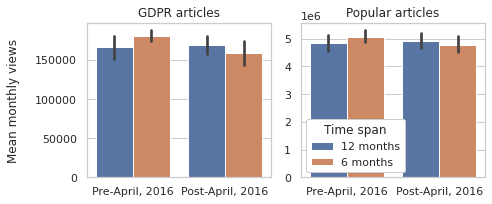

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

df_means_trmt = barplot_mean(g_treatment, interruption_date, ax=ax[0])
df_means_ctrl = barplot_mean(g_control, interruption_date, ax=ax[1])

ax[1].set_ylabel('')
ax[0].set_title('GDPR articles')
ax[1].set_title('Popular articles')
ax[0].legend().remove()
plt.tight_layout()
plt.savefig('figs/means_adoption.eps')

# ATTEMPT TO MAKE ONE LEGEND ABOVE SUBPLOTS
#handles, labels = ax[1].get_legend_handles_labels()
#ax[1].legend().remove()
#ax[0].legend().remove()
#fig.legend(handles, labels, title='Time span', ncol=2, loc=(.5, .8))
#plt.tight_layout()

In [47]:
df_means_trmt

Pageviews
timing           Time span               
Post-April, 2016 12 months  169041.818182
                 6 months   159356.166667
Pre-April, 2016  12 months  166935.250000
                 6 months   181017.200000

In [48]:
df_means_ctrl

Pageviews
timing           Time span              
Post-April, 2016 12 months  4.937903e+06
                 6 months   4.793713e+06
Pre-April, 2016  12 months  4.864481e+06
                 6 months   5.080797e+06

## Immediate change

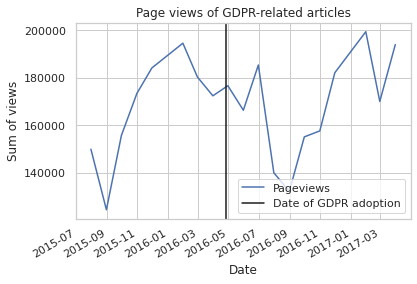

In [49]:
g_treatment.plot()
plt.axvline(interruption_date, color='k', label='Date of GDPR adoption')
plt.title('Page views of GDPR-related articles')
plt.ylabel('Sum of views');
plt.legend();

In [50]:
compute_immediate_change(g_treatment, interruption_date)

2016-03 vs 2016-04 : +4234, +2.455%
2016-04 vs 2016-05 : -10296, -5.827%


In [51]:
compute_immediate_change(g_control, interruption_date)

2016-03 vs 2016-04 : -82216, -1.679%
2016-04 vs 2016-05 : +164059, +3.408%


## C. ITS Regression

In [52]:
# Compute trends predictions for treatment datasets
fit_formula = 'Pageviews ~ time + intervention + postslope'

temp_treatment, reference_point = monthly_views_formatting(g_treatment, interruption_date)
ypred_treatment, res_treatment = fit_model(formula=fit_formula, 
                                           data=temp_treatment, 
                                           predictor=temp_treatment, 
                                           seed=2,
                                           return_res=True)

# Compute trends predictions for control datasets
temp_control, reference_point = monthly_views_formatting(g_control, interruption_date)
ypred_control, res_control = fit_model(formula=fit_formula, 
                                       data=temp_control, 
                                       predictor=temp_control, 
                                       seed=2,
                                       return_res=True)

In [53]:
res_treatment.summary()

/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Pageviews   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     2.219
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.128
Time:                        19:02:46   Log-Likelihood:                -212.24
No. Observations:                  19   AIC:                             432.5
Df Residuals:                      15   BIC:                             436.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.368e+05   1.51e+04      9.077      0.000    1.05e+05    1.69e+05
time          6705.5714   2983.553      2.248      0.040     346.278    1.31e+04
intervention -3.514e+04   1.77e+04     -1.989      0.065   -7.28e+04    2517.504
postslope    -4409.5987   3507.190     -1.257      0.228   -1.19e+04    3065.799
==============================================================================
Omnibus:                        1.992   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.369   Jarque-Bera (JB):                1.322
Skew:                          -0.398   Prob(JB):                        0.516
Kurtosis:                       1.982   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
res_control.summary()

/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Pageviews   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.179
Date:                Thu, 17 Dec 2020   Prob (F-statistic):              0.351
Time:                        19:02:46   Log-Likelihood:                -272.16
No. Observations:                  19   AIC:                             552.3
Df Residuals:                      15   BIC:                             556.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.296e+06   3.53e+05     12.177      0.000    3.54e+06    5.05e+06
time          1.263e+05   6.99e+04      1.807      0.091   -2.27e+04    2.75e+05
intervention -4.684e+05   4.14e+05     -1.132      0.275   -1.35e+06    4.13e+05
postslope    -1.096e+05   8.21e+04     -1.335      0.202   -2.85e+05    6.54e+04
==============================================================================
Omnibus:                        1.253   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                1.100
Skew:                           0.441   Prob(JB):                        0.577
Kurtosis:                       2.217   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
save_regression_summary(res_treatment, 'range_1_treatment.tex')
save_regression_summary(res_control, 'range_1_control.tex')

/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/maousi/anaconda3/envs/ada/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [56]:
# Compute 95% confidence intervals for each monthly estimated average
y_error_treatment = bootstrap_CI(temp_treatment, 200, fit_formula)
y_error_control = bootstrap_CI(temp_control, 200, fit_formula)

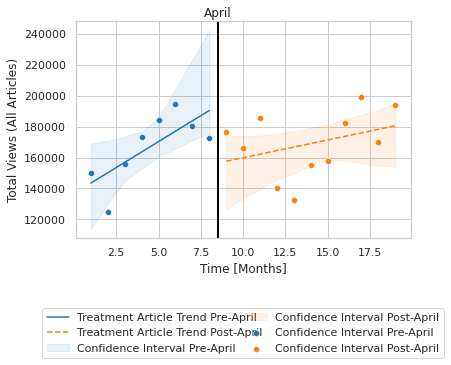

In [57]:
# Plot the treatment group trends before and after the adoption of the regulation
plotting('April', 'Treatment', reference_point, temp_treatment, ypred_treatment, y_error_treatment)
         
plt.savefig('figs/April_treament_trend.pdf', bbox_inches='tight')

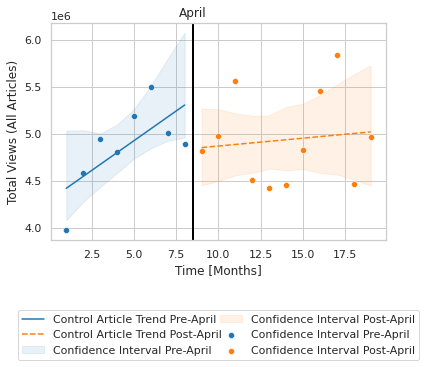

In [58]:
# Plot the control group trends before and after the lauch of the regulation
plotting('April', 'Control', reference_point, temp_control, ypred_control, y_error_control)

plt.savefig('figs/April_control_trend.pdf', bbox_inches='tight')

---
# GPDR Beggining of enforcement
The GDPR regulation was applied starting from the $25^{th}$ of May $2018$ for every country of the European Union (EU) and European Economic Area (EEA). We aim to answer the following questions regarding the event : 
* Is there an inverse chilling effect (e.g. immediate spike) following the day when the regulation became effective?
* Has there been a change in trends in the viewing of critical terms related to the regulation after the event?

We will thus answer these questions using the analysis methods from the reference paper and draw conclusions.

## A. Monthly Aggregation

In [59]:
# Date of interruption event
interruption_date = '2018-05-25'

In [60]:
# Keep +/- 12 months around interruption date
time_delta = np.timedelta64(12, 'M')

g_treatment = extract_around_date(df_monthly, interruption_date, time_delta)
g_control = extract_around_date(df_monthly_ctrl, interruption_date, time_delta)

# Illustrate the two first and last dates computed for the treatment group
g_treatment.iloc[[0,1,-2,-1]]

,Pageviews
Date,
2017-05-31,177165.0
2017-06-30,159184.0
2019-03-31,220649.0
2019-04-30,191018.0


In [61]:
# Illustrate the two first and last dates computed for the control group
g_control.iloc[[0, 1, -2, -1]]

,Pageviews
Date,
2017-05-31,4671613
2017-06-30,4017426
2019-03-31,4530837
2019-04-30,4106553


In [62]:
# Compute trends predictions for treatment datasets
fit_formula = 'Pageviews ~ time + intervention + postslope'

temp_treatment, reference_point = monthly_views_formatting(g_treatment, interruption_date)
#temp_treatment.drop(temp_treatment.index[:3], inplace=True)
ypred_treatment, res_treatment = fit_model(formula=fit_formula, 
                                           data=temp_treatment, 
                                           predictor=temp_treatment, 
                                           seed=2,
                                           return_res=True)

# Compute trends predictions for control datasets
temp_control, reference_point = monthly_views_formatting(g_control, interruption_date)
ypred_control, res_control = fit_model(formula=fit_formula, 
                                       data=temp_control, 
                                       predictor=temp_control, 
                                       seed=2,
                                       return_res=True)

In [63]:
save_regression_summary(res_treatment, 'range_2_treatment.tex')
save_regression_summary(res_control, 'range_2_control.tex')

## B. Mean Computation

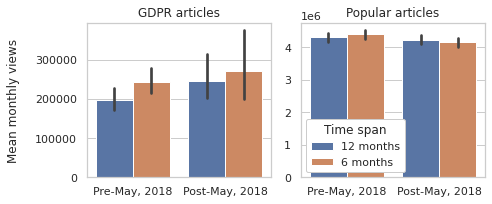

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

barplot_mean(g_treatment, interruption_date, ax=ax[0])
barplot_mean(g_control, interruption_date, ax=ax[1])

ax[1].set_ylabel('')
ax[0].set_title('GDPR articles')
ax[1].set_title('Popular articles')
ax[0].legend().remove()
plt.tight_layout()
plt.savefig('figs/means_enforcement.eps')

## C. ITS Regression

In [65]:
compute_immediate_change(g_treatment, interruption_date)

2018-04 vs 2018-05 : +218172, +71.34%
2018-05 vs 2018-06 : -219102, -41.81%


In [66]:
compute_immediate_change(g_control, interruption_date)

2018-04 vs 2018-05 : -115908, -2.694%
2018-05 vs 2018-06 : +153892, +3.676%


In [67]:
# Compute 95% confidence intervals for each monthly estimated average
y_error_treatment = bootstrap_CI(temp_treatment, 200, fit_formula)
y_error_control = bootstrap_CI(temp_control, 200, fit_formula)

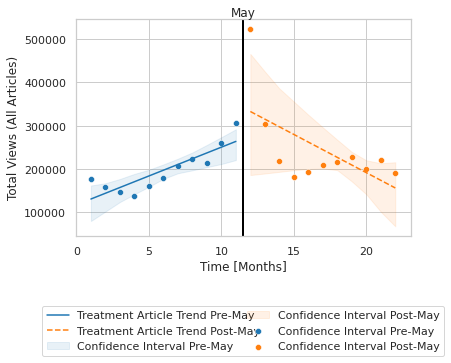

In [68]:
# Plot the treatment group trends before and after the lauch of the regulation
plotting('May', 'Treatment', reference_point, temp_treatment, ypred_treatment, y_error_treatment)

plt.savefig('figs/May_treament_trend.pdf', bbox_inches='tight')

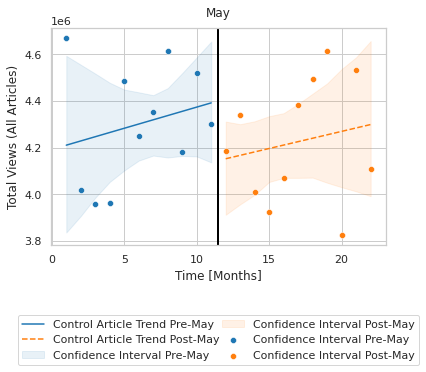

In [69]:
# Plot the control group trends before and after the lauch of the regulation
plotting('May', 'Control', reference_point, temp_control, ypred_control, y_error_control)

plt.savefig('figs/May_control_trend.pdf', bbox_inches='tight')

# Conclusion